In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [360]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_juli.csv", sep=",")

In [361]:
df.dropna(inplace=True)

In [362]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [363]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [364]:
candidate_lags = range(1, 12) 

In [365]:
cutoffs = pd.date_range(
    start="2020-08-31",   # first end-of-month
    end="2021-08-31",     # last end-of-month
    freq="ME"              # month-end
).to_list()

In [366]:
cutoffs

[Timestamp('2020-08-31 00:00:00'),
 Timestamp('2020-09-30 00:00:00'),
 Timestamp('2020-10-31 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00'),
 Timestamp('2021-01-31 00:00:00'),
 Timestamp('2021-02-28 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-30 00:00:00'),
 Timestamp('2021-07-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00')]

In [367]:
###resultat valg 2021
valg = {
    "Ap": [26.3],
    "Høyre": [20.4],
    "Frp": [11.6],
    "SV": [7.6],
    "Sp": [13.5],
    "KrF": [3.8],
    "Venstre": [4.6],
    "MDG": [3.9],
    "Rødt": [4.7],
    "Andre": [3.6],
}

###resultat valg 2017
valg = {
    "Ap": [27.4],
    "Høyre": [25.0],
    "Frp": [15.2],
    "SV": [7.6],
    "Sp": [13.5],
    "KrF": [3.8],
    "Venstre": [4.6],
    "MDG": [3.9],
    "Rødt": [4.7],
    "Andre": [3.6],
}



# Lage DataFrame
valg_df = pd.DataFrame(valg)
results = []

In [368]:
for i, cutoff in enumerate(cutoffs):
    for lag in candidate_lags:
            # Fit model on training set
            df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
            df_en=df_en.loc[df_en.index <= cutoff]
            
            df_en_val = df_en.diff().dropna() 
            df_orig=df_en
            model = VAR(df_en_val)
            
            model_fitted = model.fit(maxlags=lag, trend='n')

            steps = len(cutoffs) - i + 1 

            #print(f"lag={lag}, steps={steps} and cutoff={cutoff}")
                
            forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps)
            #print(forecast)
            forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
        
            last_actual_value = df_orig.iloc[-1]  # Last known actual data point
    
            forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    
            forecast_df = forecast_df.cumsum() + last_actual_value
            date_to_extract = "2021-09-30"
            estimate_row = forecast_df.loc[date_to_extract]
            #print(estimate_row.values)
            #print(valg2021_df.values)

            y_true = valg_df.values.reshape(1, -1)   
            y_pred = estimate_row.values.reshape(1, -1)  
            # Compute error metric (MSE here)
            mse = mean_squared_error(y_true, y_pred)
            mse_pp = mean_squared_error(y_true, last_actual_value.values.reshape(1, -1))
    
            results.append((cutoff,lag,steps, mse, mse_pp))


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

In [369]:
last_actual_value

Ap         24.0
Hoyre      20.1
Frp        10.3
SV          8.8
SP         14.1
KrF         3.6
Venstre     4.1
MDG         5.5
Rodt        5.2
Andre       4.4
Name: 2021-08-31 00:00:00, dtype: float64

In [371]:
results_df=pd.DataFrame(results, columns=["cutoff", "lag", "steps", "MSE", "mse_pp"])

In [372]:
results_df

,cutoff,lag,steps,MSE,mse_pp
0,2020-08-31,1,14,3.164533,3.704
1,2020-08-31,2,14,2.825075,3.704
2,2020-08-31,3,14,2.792934,3.704
3,2020-08-31,4,14,2.126949,3.704
4,2020-08-31,5,14,1.847768,3.704
...,...,...,...,...,...
138,2021-08-31,7,2,2.843612,1.261
139,2021-08-31,8,2,3.954047,1.261
140,2021-08-31,9,2,3.342949,1.261
141,2021-08-31,10,2,10.024744,1.261


In [373]:
best_lags = results_df.loc[results_df.groupby("cutoff")["MSE"].idxmin()]

In [374]:
best_lags

,cutoff,lag,steps,MSE,mse_pp
4,2020-08-31,5,14,1.847768,3.704
11,2020-09-30,1,13,2.978873,3.638
32,2020-10-31,11,12,2.412231,5.407
33,2020-11-30,1,11,5.771942,6.120
52,2020-12-31,9,10,6.259598,9.105
61,2021-01-31,7,9,0.460465,3.041
72,2021-02-28,7,8,0.913868,3.022
83,2021-03-31,7,7,2.908469,3.404
92,2021-04-30,5,6,3.798125,4.033
101,2021-05-31,3,5,2.298797,2.323


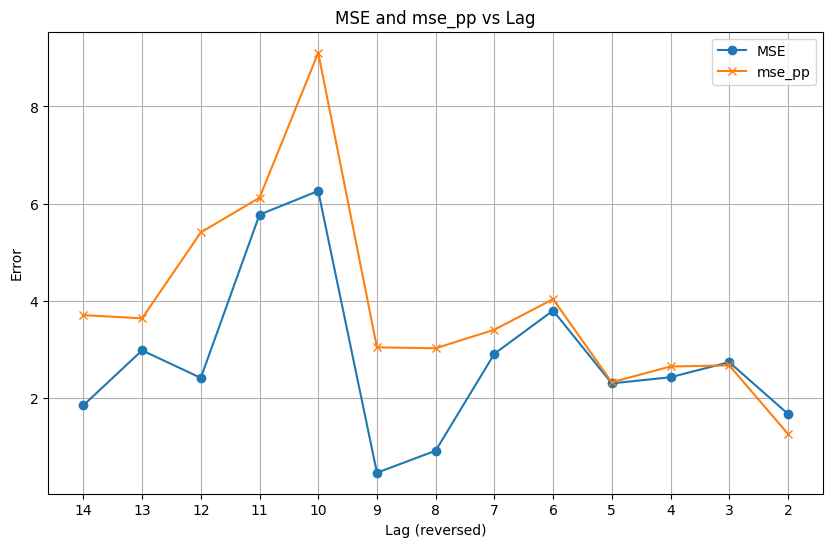

In [375]:
df_sorted = best_lags.sort_values("steps", ascending=True)  # reverse lag order for x-axis

plt.figure(figsize=(10, 6))
plt.plot(df_sorted["steps"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["steps"], df_sorted["mse_pp"], marker='x', label="mse_pp")

plt.xlabel("Lag (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs Lag")
plt.xticks(df_sorted["steps"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()

In [376]:
filtered = results_df[results_df["lag"] == results_df["steps"]]

In [377]:
filtered

,cutoff,lag,steps,MSE,mse_pp
43,2020-11-30,11,11,7.127495,6.120
53,2020-12-31,10,10,9.699107,9.105
63,2021-01-31,9,9,1.929326,3.041
73,2021-02-28,8,8,1.376045,3.022
83,2021-03-31,7,7,2.908469,3.404
93,2021-04-30,6,6,5.535741,4.033
103,2021-05-31,5,5,6.493144,2.323
113,2021-06-30,4,4,3.660684,2.647
123,2021-07-31,3,3,2.735957,2.670
133,2021-08-31,2,2,2.902762,1.261


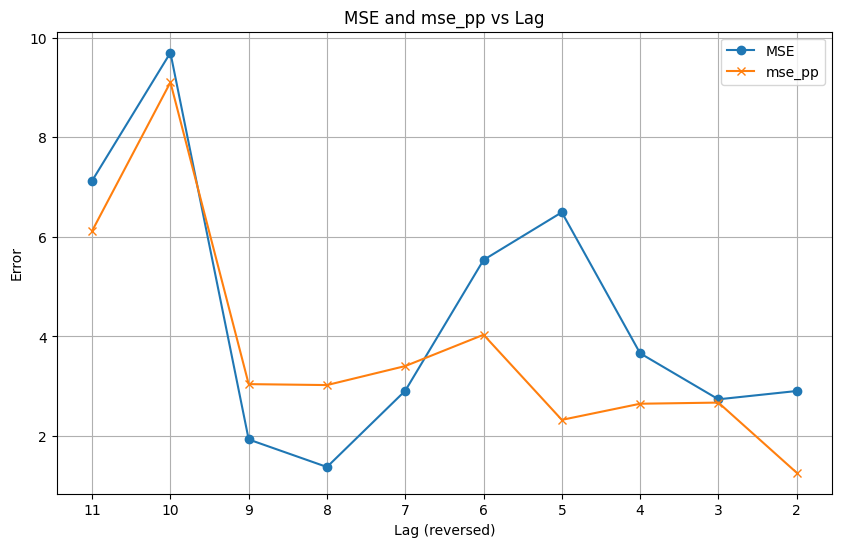

In [378]:
df_sorted = filtered.sort_values("lag", ascending=False)  # reverse lag order for x-axis

plt.figure(figsize=(10, 6))
plt.plot(df_sorted["lag"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["lag"], df_sorted["mse_pp"], marker='x', label="mse_pp")

plt.xlabel("Lag (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs Lag")
plt.xticks(df_sorted["lag"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()